## DA3 project 

In [129]:
import os
import sys
import warnings
from typing import List
import copy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
# from patsy import dmatrices
from stargazer.stargazer import Stargazer
#from utils.utils import lspline

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

In [216]:
path = os.path.join('data', 'morg-2014-emp.csv') # this will produce a path with the right syntax for your operating system
path


'data/morg-2014-emp.csv'

In [217]:
df = pd.read_csv(path, index_col = 0)
df.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,...,ownchild,chldpres,prcitshp,state,ind02,occ2012,class,unionmme,unioncov,lfsr94
3,2600310997690,January,AL,3151.6801,1692.00,40,43,1,NaN,29,...,0,0,"Native, Born In US",63,Employment services (5613),630,"Private, For Profit",No,No,Employed-At Work
5,75680310997590,January,AL,3457.1138,450.00,40,41,2,NaN,27,...,2,6,"Native, Born In US",63,Outpatient care centers (6214),5400,"Private, For Profit",No,No,Employed-Absent
6,75680310997590,January,AL,3936.9110,1090.00,60,41,2,NaN,30,...,2,6,"Native, Born In US",63,"Motor vehicles and motor vehicle equipment manufacturing (3361, 3362, 3363)",8140,"Private, For Profit",No,No,Employed-At Work
10,179140131100930,January,AL,3288.3640,769.23,40,40,1,NaN,48,...,2,4,"Native, Born In US",63,"**Publishing, except newspapers and software (5111 exc. 51111)",8255,"Private, For Profit",Yes,NaN,Employed-At Work
11,179140131100930,January,AL,3422.8500,826.92,40,43,1,NaN,46,...,2,4,"Native, Born In US",63,"Banking and related activities (521, 52211,52219)",5940,"Private, For Profit",No,No,Employed-At Work


## 1. Data Preparation

We filtered for all occupations in the teaching department, including primary school, middle school, high school teachers, and teaching assistants. To enhance the dataset, we performed feature engineering by calculating the hourly wage (w) as weekly earnings divided by the number of hours worked. We also created the log of the hourly wage (lnw) to handle its skewed distribution. Additionally, we filtered the dataset to include only observations where working hours were greater than 20, focusing on part-time and full-time workers. Observations with weekly earnings or hourly wages less than or equal to zero were removed. Lastly, the data was sorted by age to prepare for visualization.

In [223]:
# Filtering for teaching occupations 
selected_occupation_codes = [2200, 2300, 2310, 2320, 2330, 2340, 2540]
df = df[df['occ2012'].isin(selected_occupation_codes)]

#filter for working hours and earnings per week
df = df.query("uhours >= 20 & earnwke > 0")

#feature engineering
df["w"] = df["earnwke"] / df["uhours"]
df["lnw"] = np.log(df["w"])

# Sort the data by age
df.sort_values(by = 'age', inplace = True) 

df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8866 entries, 262839 to 221450
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   hhid      8866 non-null   int64  
 1   intmonth  8866 non-null   object 
 2   stfips    8866 non-null   object 
 3   weight    8866 non-null   float64
 4   earnwke   8866 non-null   float64
 5   uhours    8866 non-null   int64  
 6   grade92   8866 non-null   int64  
 7   race      8866 non-null   int64  
 8   ethnic    709 non-null    float64
 9   age       8866 non-null   int64  
 10  sex       8866 non-null   int64  
 11  marital   8866 non-null   int64  
 12  ownchild  8866 non-null   int64  
 13  chldpres  8866 non-null   int64  
 14  prcitshp  8866 non-null   object 
 15  state     8866 non-null   object 
 16  ind02     8866 non-null   object 
 17  occ2012   8866 non-null   int64  
 18  class     8866 non-null   object 
 19  unionmme  8866 non-null   object 
 20  unioncov  5305 non-null   ob

## 2. Visualizations and EDA

We visualized the distribution of hourly wages and observed a long right tail, indicating the presence of highly skewed data. To address this, we used the log of the hourly wage (lnw), resulting in a more normally distributed metric. We then plotted descriptive statistics by gender, age, and number of hours worked, leading to the decision to include quadratic terms for age and hours worked. These terms were created to account for potential non-linear relationships.

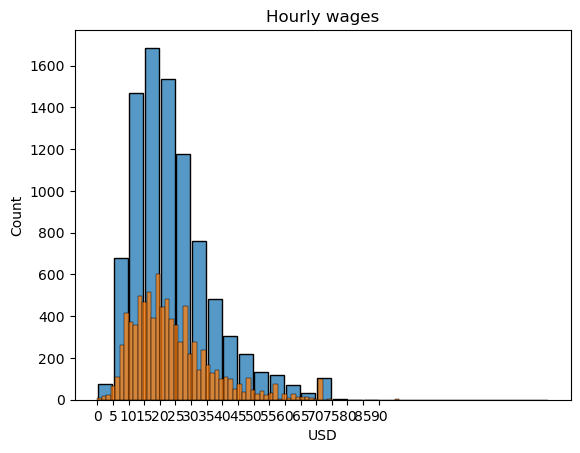

In [224]:
sns.histplot(df.w, shrink=0.9, bins = range(0,95,5))
plt.xticks(range(0,95,5))
plt.xlabel('USD')
plt.title('Hourly wages');

sns.histplot(df.w)
plt.xticks(range(0,95,5))
plt.xlabel('USD')
plt.title('Hourly wages');

#wage - log trabsformed 

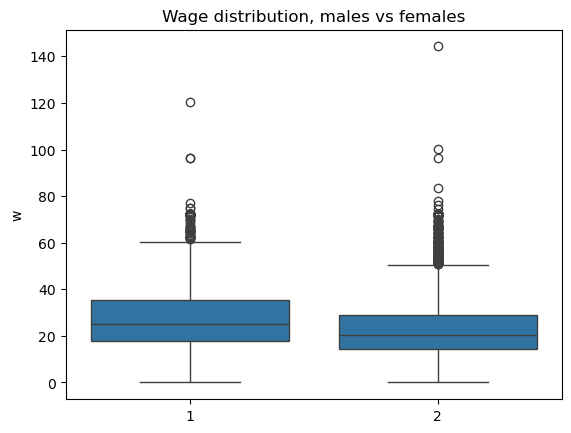

In [233]:
sns.boxplot(data = df, x = 'sex', y = 'w')
plt.xlabel(None)
plt.title('Wage distribution, males vs females');

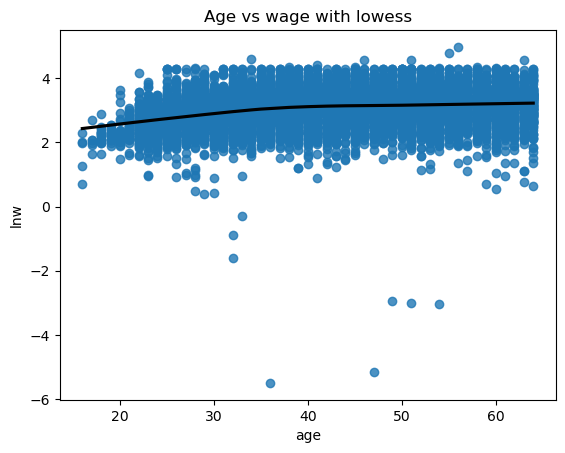

In [226]:
sns.regplot(
    data = df, x = 'age', y = 'lnw', 
    lowess = True, line_kws = {'color' : 'k'})
plt.title('Age vs wage with lowess');

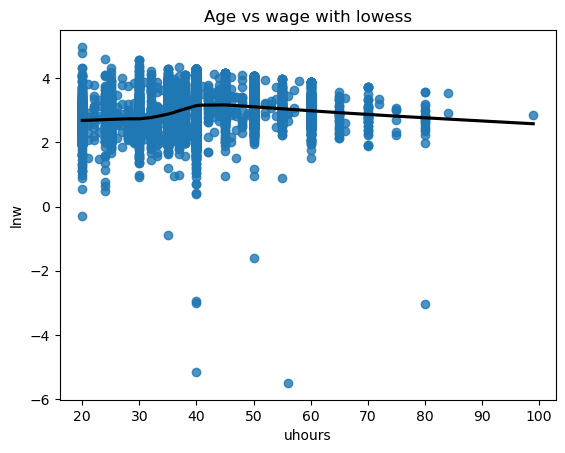

In [227]:
sns.regplot(
    data = df, x = 'uhours', y = 'lnw', 
    lowess = True, line_kws = {'color' : 'k'})
plt.title('Age vs wage with lowess');

In [228]:
# Square both age and uhours to see if there is a quadratic relationship
df['age_squared'] = df['age'] ** 2
df['uhours_squared'] = df['uhours'] ** 2

In [234]:
df.columns
df.sex.value_counts()

sex
2    6663
1    2203
Name: count, dtype: int64

In [235]:
#describtive stats 
df.loc[:, ["earnwke", "uhours", "w"]].describe().T

,count,mean,std,min,25%,50%,75%,max
earnwke,8866.0,978.946324,572.910399,0.230000,570.932500,884.610,1250.0,2884.6100
uhours,8866.0,40.128807,8.679614,20.000000,40.000000,40.000,40.0,99.0000
w,8866.0,24.146005,13.287039,0.004107,14.957111,21.625,30.0,144.2305


## 3. Feature Engineering 
Binary Variables

We engineered binary variables for:
	•	Education: uni_binary, hs_binary, and no_hs_binary.
	•	Race: race_white, race_black, race_asian, and race_other.
	•	Marital status, children presence, institution type (private/public), citizenship, and gender.

A value count revealed that the “no high school” group had only 50 observations, a small baseline sample. Model 3 includes all three education binary variables (university, high school, no high school), while Model 3.1 only includes the university binary variable, comparing whether an individual has a university degree. Model 3.1 was chosen for its stability, as removing the high school and no high school categories reduced potential model instability.

In [236]:
# Create binary variables
df['uni_binary'] = (df['grade92'] >= 43).astype(int)
df['hs_binary'] = df['grade92'].between(39, 42).astype(int)
df['no_hs_binary'] = (df['grade92']<= 38).astype(int)
df['race_white'] = (df['race'] == 1).astype(int)  
df['race_black'] = (df['race'] == 2).astype(int) 
df['race_asian'] = (df['race'] == 4).astype(int) 
df['race_other'] = (~df['race'].isin([1, 2, 4])).astype(int)
df['marital_binary'] = df['marital'].isin([1, 2, 3]).astype(int)
df['ownchild_binary'] = (df['ownchild'] > 0).astype(int)
df['class_private'] = df['class'].apply(lambda x: 1 if 'Private' in x else 0)
df['citizen_us'] = df['prcitshp'].apply(lambda x: 1 if 'Native' in x else 0)
df["female"] = (df.sex == 2).astype(int)

# Display the first few rows to verify
df.head()

,hhid,intmonth,stfips,weight,earnwke,uhours,grade92,race,ethnic,age,...,no_hs_binary,race_white,race_black,race_asian,race_other,marital_binary,ownchild_binary,class_private,citizen_us,female
262839,510650169340085,October,WI,1443.6986,181.2,24,37,4,NaN,16,...,1,0,0,1,0,0,0,1,1,1
161948,610009071839620,July,DE,641.9280,80.0,40,36,1,NaN,16,...,1,1,0,0,0,0,0,1,0,1
256844,910005854409202,October,PA,2983.0704,70.0,20,37,1,NaN,16,...,1,1,0,0,0,0,0,1,1,1
277197,50019501204721,November,MO,4359.5158,290.0,40,43,4,NaN,16,...,0,0,0,1,0,0,0,1,0,1
167999,432789015909962,July,ME,575.6326,400.0,40,36,1,NaN,16,...,1,1,0,0,0,0,0,1,1,1


In [257]:
df.shape
print(df.uni_binary.value_counts())
print(df.hs_binary.value_counts())
print(df.no_hs_binary.value_counts())

uni_binary
1    7141
0    1725
Name: count, dtype: int64
hs_binary
0    7197
1    1669
Name: count, dtype: int64
no_hs_binary
0    8810
1      56
Name: count, dtype: int64


## 4. Regression Models

We created several models:
	1.	Model 0: Log wage as a function of age and number of hours worked.
	2.	Model 1: Adds quadratic terms for age and hours worked, increasing  R^2  by 0.04.
	3.	Model 2: Adds gender and race variables.
	4.	Model 3: Includes all binary variables created.
	5.	Model 3.1: Includes all variables except high school and no high school binary variables.
	6.	Model 4: Adds interaction terms for gender and hours worked, and gender and marital status.

We used a stargazer table to summarize the regression results, highlighting the progression in model complexity and improvements in metrics like  R^2 .

In [238]:
import statsmodels.formula.api as smf

# Reg0: Log wage as a function of age and U hours
reg_0 = smf.ols(formula='lnw ~ age + uhours', data=df).fit(cov_type='HC0')

# Reg1: Adds squared terms for age and U hours
reg_1 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared', data=df).fit(cov_type='HC0')

# Reg2: Includes gender and race
reg_2 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + race_white', data=df).fit(cov_type='HC0')

# Reg3: Includes everything (race, marital status, children, work type, citizenship)
reg_3 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
                        'hs_binary +  race_white + race_black + race_asian + marital_binary + '
                        'ownchild_binary + class_private + citizen_us', data=df).fit(cov_type='HC0')

# Reg3.1: Same as Reg3 but excludes high school and no high school (only university)
reg_3_1 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
                          'race_white + race_black + race_asian + marital_binary + '
                          'ownchild_binary + class_private + citizen_us', data=df).fit(cov_type='HC0')

# Reg4: Includes interaction terms
reg_4 = smf.ols(formula='lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
                        'race_white + race_black + race_asian  + marital_binary + '
                        'ownchild_binary + class_private + citizen_us + '
                        'female:uhours + female:marital_binary', data=df).fit(cov_type='HC0')

from stargazer.stargazer import Stargazer

# Create Stargazer table
stargazer = Stargazer([reg_0, reg_1, reg_2, reg_3, reg_3_1, reg_4])
stargazer.title("Regression Results")
stargazer.custom_columns(['Reg0', 'Reg1', 'Reg2', 'Reg3', 'Reg3.1', 'Reg4'], [1, 1, 1, 1, 1, 1])

# Print HTML table (for Jupyter)
stargazer

# Alternatively, print LaTeX table (for reports)
# print(stargazer.render_latex())

Variance Inflation Factor (VIF)

To address concerns about multicollinearity, we calculated the VIF for all predictors. Most variables had acceptable VIF values except race_white, which had a high VIF due to the large proportion of white individuals (80% of the dataset). While this could indicate collinearity, no corrective measures were taken as it reflects the demographic composition.

In [240]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[['female', 'marital_binary', 'ownchild_binary', 'class_private', 'citizen_us', 'race_white', 'race_black', 'race_asian', 'race_other']]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
print(vif)

         VIF          Feature
0   1.004194           female
1   1.177847   marital_binary
2   1.142120  ownchild_binary
3   1.014041    class_private
4   1.254402       citizen_us
5  19.253833       race_white
6   2.602933       race_black
7   1.279306       race_asian
8   1.437636       race_other


In [241]:
df.race_white.value_counts()

race_white
1    7565
0    1301
Name: count, dtype: int64

## 5. Model Comparison

We evaluated all models using metrics such as  R^2 , adjusted  R^2 , AIC, BIC, and RMSE. Model 3.1 demonstrated a good balance between simplicity and predictive power, with an RMSE comparable to more complex models like Model 4 but improved stability due to the removal of small baseline groups.

Key Insights:
	•	Increasing complexity improved  R^2  but had diminishing returns after Model 3.1.
	•	Model 4, with interaction terms, provided negligible improvements over Model 3.1 but added complexity.

In [243]:
import numpy as np
import pandas as pd

# List of models and their names
models = [reg_0, reg_1, reg_2, reg_3, reg_3_1, reg_4]
model_names = ['basic', 'squared terms', 'With Gender & Race', 'incl all edu', 'full model', 'with interactions']

# Initialize an empty list to store the results
results = []

# Calculate metrics for each model
for model, name in zip(models, model_names):
    # Calculate RMSE
    residuals = model.resid
    rmse = np.sqrt(np.mean(residuals**2))

    # Append model results to the list
    results.append({
        'Model': name,
        'R-squared': model.rsquared,
        'Adjusted R-squared': model.rsquared_adj,
        'AIC': model.aic,
        'BIC': model.bic,
        'RMSE': rmse
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the comparison table
results_df

,Model,R-squared,Adjusted R-squared,AIC,BIC,RMSE
0,basic,0.064232,0.064021,14719.760098,14741.030035,0.554797
1,squared terms,0.109459,0.109057,14284.552599,14320.002494,0.541224
2,With Gender & Race,0.139964,0.139382,13979.530309,14029.160162,0.531874
3,incl all edu,0.235976,0.234768,12946.013792,13052.363477,0.501307
4,full model,0.234691,0.233567,12958.915163,13058.174870,0.501728
5,with interactions,0.235056,0.233760,12958.685235,13072.124900,0.501609


Discussion of Results

Model 4 was chosen as the best candidate for this analysis due to its balance of simplicity, interpretability, and strong performance across key metrics. Unlike Model 3, which includes a separate binary variable for high school education, Model 4 focuses solely on whether an individual has a university degree. This decision avoids potential instability caused by the small “no high school” group, which accounts for only ~50 observations out of 8,300, while still providing meaningful insights into the impact of education on wages.

When compared to the other models, Model 4 performs similarly to Model 3 in terms of adjusted R-squared (0.2336 vs. 0.2347) and RMSE (0.5017 vs. 0.5013), while slightly increasing AIC and BIC. However, it outperforms simpler models like Model 0, Model 1, and Model 2, all of which have lower R-squared values and higher RMSE. Compared to Model 5, which includes interaction terms, Model 4 achieves nearly identical metrics for adjusted R-squared (0.2336 vs. 0.2338) and RMSE (0.5017 vs. 0.5016), while having slightly better BIC (13058.17 vs. 13072.12). These similarities indicate that the additional complexity in Model 5 does not meaningfully enhance the model’s performance. By simplifying the education variable and avoiding potential overfitting, Model 4 stands out as the most reliable and interpretable model for this analysis. A train-test split and cross-validation will further validate its robustness and predictive accuracy.

## 6. Test-train split for all models 

In [245]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Define a function for 80-20 train-test split cross-validation
def cross_validate_80_20(model_formula, data):
    # Train-test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    
    # Fit model on training set
    model = smf.ols(formula=model_formula, data=train).fit(cov_type='HC0')
    
    # Predict on test set
    y_pred = model.predict(test)
    y_test = test['lnw']  # Dependent variable
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Model formulas
formulas = {
    'Reg0': 'lnw ~ age + uhours',
    'Reg1': 'lnw ~ age + uhours + age_squared + uhours_squared',
    'Reg2': 'lnw ~ age + uhours + age_squared + uhours_squared + female + race_white',
    'Reg3': 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
            'hs_binary + race_white + race_black + race_asian + marital_binary + '
            'ownchild_binary + class_private + citizen_us',
    'Reg3.1': 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
              'race_white + race_black + race_asian + marital_binary + '
              'ownchild_binary + class_private + citizen_us',
    'Reg4': 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
            'race_white + race_black + race_asian + marital_binary + '
            'ownchild_binary + class_private + citizen_us + '
            'female:uhours + female:marital_binary'
}

# Cross-validate each model and store RMSE results
results = []
for name, formula in formulas.items():
    rmse = cross_validate_80_20(formula, df)
    results.append({'Model': name, 'RMSE': rmse})

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

    Model      RMSE
0    Reg0  0.527496
1    Reg1  0.510736
2    Reg2  0.499429
3    Reg3  0.459817
4  Reg3.1  0.460136
5    Reg4  0.459862


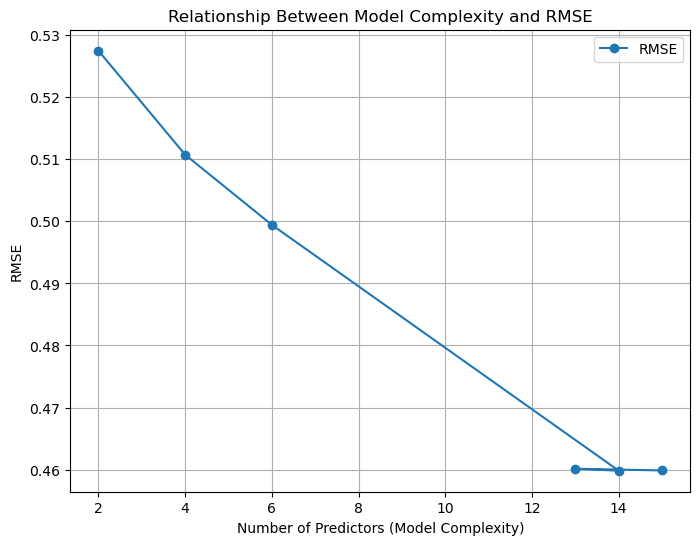

In [246]:
import matplotlib.pyplot as plt

# Define model names and number of predictors
model_names = ['Reg0', 'Reg1', 'Reg2', 'Reg3', 'Reg3.1', 'Reg4']
num_predictors = [2, 4, 6, 14, 13, 15]  # Number of predictors in each model
rmse_values = [0.527496, 0.510736, 0.499429, 0.459817, 0.460136, 0.459862]  # RMSE values

# Plot RMSE vs. Model Complexity
plt.figure(figsize=(8, 6))
plt.plot(num_predictors, rmse_values, marker='o', label='RMSE')
plt.title('Relationship Between Model Complexity and RMSE')
plt.xlabel('Number of Predictors (Model Complexity)')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

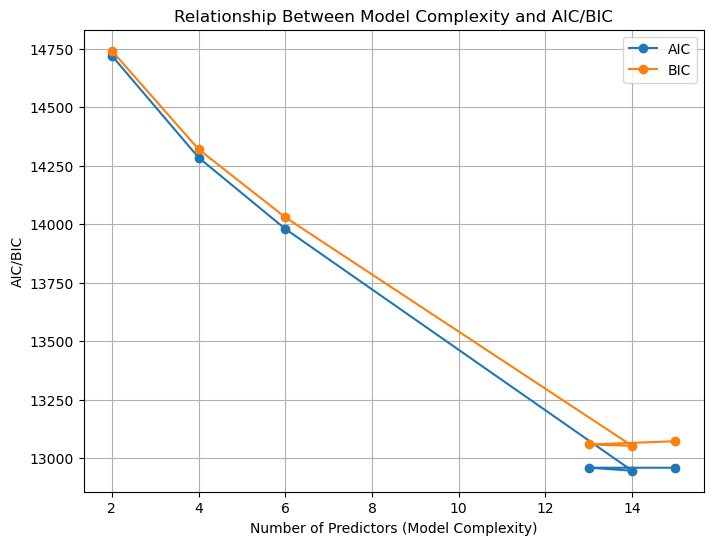

In [247]:
# AIC and BIC values
aic_values = [14719.76, 14284.55, 13979.53, 12946.01, 12958.91, 12958.68]
bic_values = [14741.03, 14320.00, 14029.16, 13052.36, 13058.17, 13072.12]

# Plot AIC and BIC vs. Model Complexity
plt.figure(figsize=(8, 6))
plt.plot(num_predictors, aic_values, marker='o', label='AIC')
plt.plot(num_predictors, bic_values, marker='o', label='BIC')
plt.title('Relationship Between Model Complexity and AIC/BIC')
plt.xlabel('Number of Predictors (Model Complexity)')
plt.ylabel('AIC/BIC')
plt.grid(True)
plt.legend()
plt.show()

## 7. k-fold cross validation RMSE

In [248]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# Define a function for k-fold cross-validation
def k_fold_cross_validate(model_formula, data, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []

    print(f"RMSE for each fold for formula: {model_formula}")
    
    for fold, (train_index, test_index) in enumerate(kf.split(data), 1):
        train, test = data.iloc[train_index], data.iloc[test_index]
        
        # Fit model on training set
        model = smf.ols(formula=model_formula, data=train).fit(cov_type='HC0')
        
        # Predict on test set
        y_pred = model.predict(test)
        y_test = test['lnw']  # Dependent variable
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        
        # Print RMSE for the current fold
        print(f"Fold {fold}: RMSE = {rmse:.4f}")

    # Calculate and print average RMSE
    avg_rmse = np.mean(rmse_scores)
    print(f"Average RMSE: {avg_rmse:.4f}\n")
    
    return rmse_scores, avg_rmse

# Model formulas
formulas = {
    'Reg0': 'lnw ~ age + uhours',
    'Reg1': 'lnw ~ age + uhours + age_squared + uhours_squared',
    'Reg2': 'lnw ~ age + uhours + age_squared + uhours_squared + female + race_white',
    'Reg3': 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
            'hs_binary + race_white + race_black + race_asian + marital_binary + '
            'ownchild_binary + class_private + citizen_us',
    'Reg3.1': 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
              'race_white + race_black + race_asian + marital_binary + '
              'ownchild_binary + class_private + citizen_us',
    'Reg4': 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + '
            'race_white + race_black + race_asian + marital_binary + '
            'ownchild_binary + class_private + citizen_us + '
            'female:uhours + female:marital_binary'
}

# Cross-validate each model and store RMSE results
results = []
for name, formula in formulas.items():
    rmse_scores, avg_rmse = k_fold_cross_validate(formula, df, n_splits=5)
    results.append({'Model': name, 'Per-Fold RMSE': rmse_scores, 'Average RMSE': avg_rmse})

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

# Display the results
pd.set_option('display.max_colwidth', None)  # Ensure long lists of per-fold RMSE are fully displayed
print(results_df)

RMSE for each fold for formula: lnw ~ age + uhours
Fold 1: RMSE = 0.5275
Fold 2: RMSE = 0.5580
Fold 3: RMSE = 0.6013
Fold 4: RMSE = 0.5252
Fold 5: RMSE = 0.5606
Average RMSE: 0.5545

RMSE for each fold for formula: lnw ~ age + uhours + age_squared + uhours_squared
Fold 1: RMSE = 0.5107
Fold 2: RMSE = 0.5469
Fold 3: RMSE = 0.5844
Fold 4: RMSE = 0.5146
Fold 5: RMSE = 0.5494
Average RMSE: 0.5412

RMSE for each fold for formula: lnw ~ age + uhours + age_squared + uhours_squared + female + race_white
Fold 1: RMSE = 0.4994
Fold 2: RMSE = 0.5382
Fold 3: RMSE = 0.5742
Fold 4: RMSE = 0.5044
Fold 5: RMSE = 0.5433
Average RMSE: 0.5319

RMSE for each fold for formula: lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + hs_binary + race_white + race_black + race_asian + marital_binary + ownchild_binary + class_private + citizen_us
Fold 1: RMSE = 0.4598
Fold 2: RMSE = 0.5113
Fold 3: RMSE = 0.5446
Fold 4: RMSE = 0.4726
Fold 5: RMSE = 0.5195
Average RMSE: 0.5016

RMSE for each fo

In [249]:
df.lnw.describe()

count    8866.000000
mean        3.037946
std         0.573554
min        -5.495028
25%         2.705187
50%         3.073850
75%         3.401197
max         4.971413
Name: lnw, dtype: float64

## 8. residuals analysis for best performing model (reg_3.1)

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import numpy as np

# Train-test split (80/20)
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Define the formula for Model 3.1
formula_3_1 = 'lnw ~ age + uhours + age_squared + uhours_squared + female + uni_binary + ' \
               'race_white + race_black + race_asian + marital_binary + ' \
               'ownchild_binary + class_private + citizen_us'

# Fit the model on the training data
model_3_1 = smf.ols(formula=formula_3_1, data=train).fit(cov_type='HC0')

# Predict on the test data
y_pred = model_3_1.predict(test)

# Calculate RMSE
y_test = test['lnw']
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE for Model 3.1: {rmse_test:.4f}")

# Optional: Display summary of the model (on training data)
print(model_3_1.summary())

Test RMSE for Model 3.1: 0.4601
                            OLS Regression Results                            
Dep. Variable:                    lnw   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     178.5
Date:                Thu, 16 Jan 2025   Prob (F-statistic):               0.00
Time:                        20:24:57   Log-Likelihood:                -5311.5
No. Observations:                7092   AIC:                         1.065e+04
Df Residuals:                    7078   BIC:                         1.075e+04
Df Model:                          13                                         
Covariance Type:                  HC0                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept 

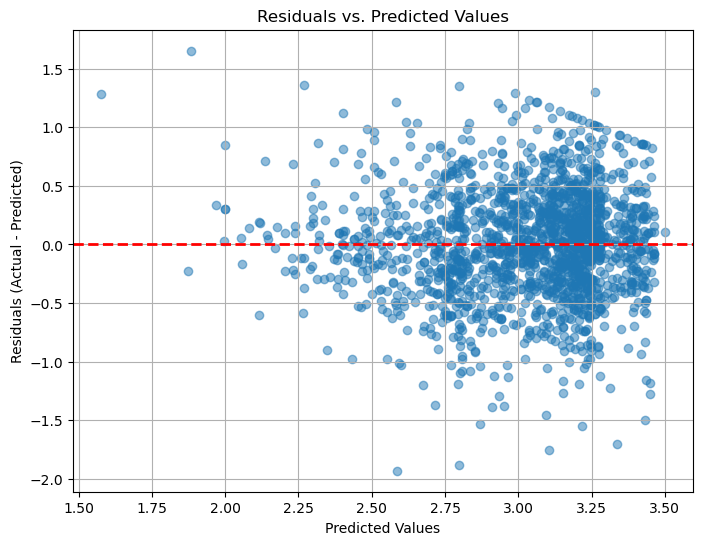

In [252]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Scatter plot of residuals vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

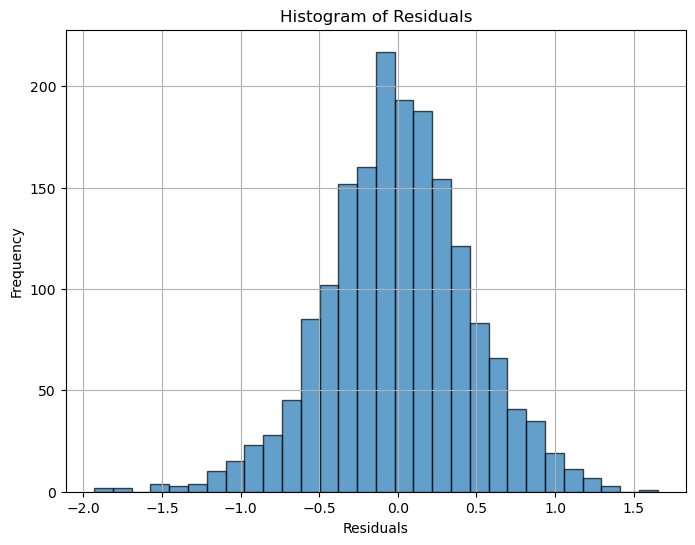

In [253]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

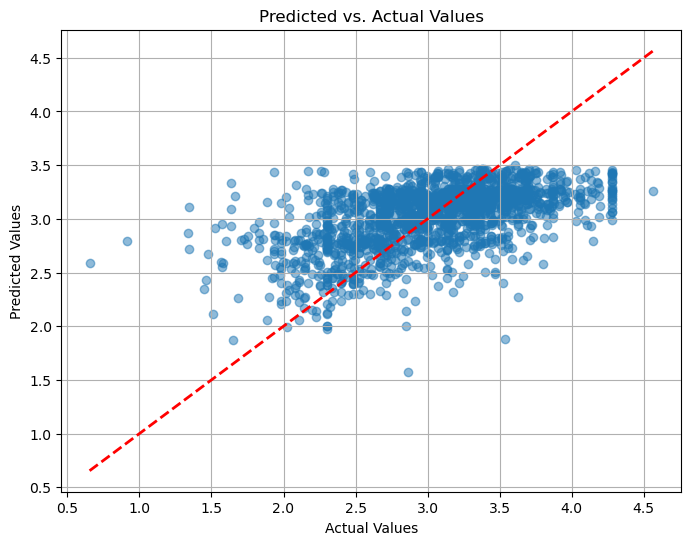

In [254]:
# Scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [255]:
mean_residual = residuals.mean()
print(f"Mean Residual: {mean_residual:.4f}")

Mean Residual: 0.0037


In [256]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

Mean Absolute Error: 0.3553
